In [ ]:
# This file costructs surrogate models for the input datasets
# Github links: https://github.com/mswang12/minDQN/blob/main/minDQN.ipynb
# Explanation link: https://pythonprogramming.net/training-deep-q-learning-dqn-reinforcement-learning-python-tutorial/?completed=/deep-q-learning-dqn-reinforcement-learning-python-tutorial/
# Explanation link 2: https://towardsdatascience.com/deep-q-learning-tutorial-mindqn-2a4c855abffc

import numpy as np     
import pandas as pd
import os
import random
import json
import math
import time
from collections import deque

# Sklearn modules
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Torch specific module imports
import torch
import gpytorch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torch.nn import functional as F

# np.random.seed(0)
# torch.manual_seed(0)    

# Plotting libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

# User defined files and classes
import sys
sys.path.append('../')
from src.ReLMM.read_data import Inputs
from src.ReLMM.predictors import Predictors
import src.ReLMM.utils_dataset as utilsd

# Tick parameters
# mpl.rcParams['text.usetex'] = True
# mpl.rcParams['text.latex.preamble'] = [
#     r'\usepackage{amsmath}',
#     r'\usepackage{amssymb}']
# Plotting parameters
plt.rcParams.update({
"text.usetex":True,
"font.family":"sans-serif",
"font.serif":["Computer Modern Roman"]})
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['ytick.minor.width'] = 1
# plt.rcParams['xtick.labelsize'] = 15
# plt.rcParams['ytick.labelsize'] = 15
# plt.rcParams['xtick.major.size'] = 5
# plt.rcParams['xtick.major.width'] = 1
# plt.rcParams['xtick.minor.size'] = 5
# plt.rcParams['xtick.minor.width'] = 1
# plt.rcParams['ytick.major.size'] = 5
# plt.rcParams['ytick.major.width'] = 1
# plt.rcParams['ytick.minor.size'] = 5
# plt.rcParams['ytick.minor.width'] = 1
# plt.rcParams['axes.labelsize'] = 15
# plt.rcParams['axes.titlesize'] = 15
# plt.rcParams['legend.fontsize'] = 15


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
class MainNeuralNetwork(nn.Module):
    def __init__(self,in_features,out_variables,num_nodes):
        super(MainNeuralNetwork,self).__init__()

        self.in_features = in_features
        # self.layer1 = nn.Linear(in_features, num_nodes,bias=True)
        # self.layer2 = nn.Linear(num_nodes,out_variables,bias=True)
        self.layer1 = nn.Linear(in_features, num_nodes,bias=True)
        self.layer2 = nn.Linear(num_nodes, num_nodes,bias=True)
        self.layer3 = nn.Linear(num_nodes,out_variables,bias=True)
        
    def forward(self, x):
        layer1_out = F.relu(self.layer1(x))
        layer2_out = F.relu(self.layer2(layer1_out))
        output = self.layer3(layer2_out)
        
        # layer1_out = F.relu(self.layer1(x)) #F.linear(self.layer1(x))
        # output = self.layer2(layer1_out)
        
        return output
    
class TargetNeuralNetwork(nn.Module):
    def __init__(self,in_features,out_variables,num_nodes):
        super(TargetNeuralNetwork,self).__init__()

        self.in_features = in_features
        # self.layer1 = nn.Linear(in_features, num_nodes,bias=True)
        # self.layer2 = nn.Linear(num_nodes,out_variables,bias=True)
        self.layer1 = nn.Linear(in_features, num_nodes,bias=True)
        self.layer2 = nn.Linear(num_nodes, num_nodes,bias=True)
        self.layer3 = nn.Linear(num_nodes,out_variables,bias=True)
        
    def forward(self, x):
        layer1_out = F.relu(self.layer1(x))
        layer2_out = F.relu(self.layer2(layer1_out))
        output = self.layer3(layer2_out)
        
        # layer1_out = F.relu(self.layer1(x)) #F.linear(self.layer1(x))
        # output = self.layer2(layer1_out)
        
        return output
    
class Train():
    
#     def __init__(self):
        
        # print('Starting training')
        
    def train_loop(self, dataloader, model, loss_fn, optimizer,lambda1,lambda2):
        
        size = len(dataloader.dataset)
        num_batches = len(dataloader)
        train_loss = 0.0
        l1_regularization, l2_regularization = 0.0, 0.0
        
        for batch, sample_batched in enumerate(dataloader):
            # Compute prediction and loss
            X = sample_batched['in_features']
            y = sample_batched['labels']
            pred = model(X)
            train_loss += loss_fn(pred, y).item()
            pred_loss = loss_fn(pred, y)
            
            all_linear1_params = torch.cat([x.view(-1) for x in model.layer1.parameters()])
            all_linear2_params = torch.cat([x.view(-1) for x in model.layer2.parameters()])
            all_linear3_params = torch.cat([x.view(-1) for x in model.layer3.parameters()])
            l1_regularization = lambda1 * (torch.norm(all_linear1_params, 1)+torch.norm(all_linear2_params, 1)+torch.norm(all_linear3_params, 1))
            l2_regularization = lambda2 * (torch.norm(all_linear1_params, 2)+torch.norm(all_linear2_params, 2)+torch.norm(all_linear3_params, 2))

            # l1_regularization = lambda1 * (torch.norm(all_linear1_params, 1)+torch.norm(all_linear2_params, 1))
            # l2_regularization = lambda2 * (torch.norm(all_linear1_params, 2)+torch.norm(all_linear2_params, 2))

            loss = pred_loss + l1_regularization + l2_regularization 

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_loss /=num_batches
        return train_loss


    def test_loop(self, dataloader, model, loss_fn):
        size = len(dataloader.dataset)
        num_batches = len(dataloader)
        test_loss, correct = 0, 0

        with torch.no_grad():
            for sample_batched in dataloader:
                X = sample_batched['in_features']
                y = sample_batched['labels']  
                pred = model(X)
                test_loss += loss_fn(pred, y).item()

        test_loss /= num_batches
        correct /= size
        # print(f"Test Error Avg loss: {test_loss:>8f} \n")
        return test_loss
    
def initial_train_agents(loss_fn,optimizer_dict,model_main,model_target,state,reward,descriptors,num_game_instances = 5):

    for iAgent in model_main.keys():
        # print(iAgent)
        absent_index = 0
        absent_reward = 0.0
        present_index = 0 
        present_reward = 0.0
        qvalue_training = np.zeros((len(reward),2))

        feature_index = int(iAgent.split('agent_')[1])
        train_NN = True
        saveModel_NN = False 
        predict_NN = False
        test_size = 0.1
        saveModel_filename = '../RL_FS_output/alloys_' + str(int(test_size*100)) + 'test_8nodes_l1_1em3.pt'
        state_input_training = state

        # First game:
        if state[0][feature_index] == 0:
            absent_index += 1
            absent_reward = reward[0]
            qvalue_training[0][0] = reward[0]
        elif state[0][feature_index] == 1:
            present_index += 1
            present_reward = reward[0]
            qvalue_training[0][1] = reward[0]

        # Remaining games:
        for iGame in range(1,num_game_instances):
            if state[iGame][feature_index] == 0:
                absent_index += 1
                absent_reward = reward[iGame]
                qvalue_training[iGame][0] = absent_reward
            elif state[iGame][feature_index] == 1:
                present_index += 1
                present_reward = reward[iGame]
                qvalue_training[iGame][1] = present_reward


        train_NN_state2XgboostOutput(state_input_training, qvalue_training, model_main[iAgent], model_target[iAgent], loss_fn, optimizer_dict[iAgent], test_size, epochs = 5)

    return model_main, model_target


In [3]:
def instantiate_agents(num_features,num_nodes,in_features,out_variables,learning_rate = 1e-3):
    
    model_main = {}
    model_target = {}
    optimizer_dict = {}
    
    # NN Policies for Q-Learning
    for iFeature in range(0,num_features):
        agent_name = 'agent_'+str(iFeature)
        model_main[agent_name] = MainNeuralNetwork(in_features,out_variables,num_nodes)
        model_target[agent_name] = TargetNeuralNetwork(in_features,out_variables,num_nodes)
        optimizer_dict[agent_name] = torch.optim.Adam(model_main[agent_name].parameters(), lr=learning_rate)
    
    # Initializing loss and optimizer
    loss_fn = nn.MSELoss()
    
    return loss_fn, optimizer_dict, model_main, model_target


In [4]:
def train_NN_state2XgboostOutput(X_stand_training, Y_stand_training, agent_main, agent_target, loss_fn, optimizer, test_size, epochs = 10):

    X_train, X_test, Y_train, Y_test = train_test_split(X_stand_training, Y_stand_training, test_size=test_size,random_state=40)
    Var_train = torch.ones(len(Y_train)) 
    Var_test = torch.ones(len(Y_test)) 
        
    # NN parameters
    batch_size = 3
    l1 = 1e-5
    l2 = 1e-5
 
    # Dataloader for pytorch
    train_data = utilsd.InputDataset(X_train,Y_train,Var_train,descriptors)
    test_data = utilsd.InputDataset(X_test,Y_test,Var_test,descriptors)

    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

    user_training = Train()

    train_loss = []
    test_loss = []
    for t in range(epochs):
        train_loss_epoch = user_training.train_loop(train_dataloader, agent_main, loss_fn, optimizer, l1, l2)
        test_loss_epoch = user_training.test_loop(test_dataloader, agent_main, loss_fn)
        train_loss.append(train_loss_epoch)
        test_loss.append(test_loss_epoch)
        if ((t+1)%100 == 0):
            print(f"Epoch {t+1}---> training error: {train_loss_epoch:>7f}, val error: {test_loss_epoch:>7f}")
        if((t+1)%10 == 0):
            agent_target.load_state_dict(agent_main.state_dict())
            # model_target.eval()
            # output_target = model_target(X_train)

        fig, ax = plt.subplots(figsize=(6,4))
        ax.plot(range(epochs),train_loss, label=f'Training Error,{train_loss_epoch:>7f}')
        ax.plot(range(epochs),test_loss, label=f'Validation Error,{test_loss_epoch:>7f}')
        ax.set_xlabel('Num. of epochs')
        ax.set_ylabel('MSE Loss')
        plt.legend()
        print("NN training Done!")
        
    return

def train_agents_inLoop(replay_memory, agent_num, agent_main, agent_target, loss_fn, optimizer, saveModel_NN, saveModel_filename, test_size, epochs = 1000):
    
    min_replay_size = 50
    if len(replay_memory) < min_replay_size:
        return
    
    # Q-learning paramaters
    learning_rate = 0.7
    discount_factor = 0.618
    
    # NN parameters
    batch_size = 10
    l1 = 1e-5
    l2 = 1e-5
    
    # Setting up input and output values for training the agent
    mini_batch = random.sample(replay_memory, min_replay_size)
    current_states = [transition[0] for transition in mini_batch]
    current_qs_list = predict_agents(current_states,agent_main).clone().detach()
    new_states = [transition[3] for transition in mini_batch]
    future_qs_list = predict_agents(new_states,agent_target).clone().detach()
    
    X = []
    Y = []
    for index, (current_state, action, reward, new_state) in enumerate(mini_batch):
        # if not done:
        max_future_q = torch.tensor(reward).to(torch.float32) + discount_factor * torch.max(future_qs_list[index])
        # max_future_q = reward + discount_factor * future_qs_list[index]
        # else:
        #     max_future_q = reward

        current_qs = current_qs_list[index]
        current_qs[action[agent_num]] = (1 - learning_rate) * current_qs[action[agent_num]] + learning_rate * max_future_q
        
        X.append(current_state)
        Y.append(current_qs)

    Y = torch.stack(Y)
    # c = torch.cat((a, b))
    # Dataloader for pytorch
    train_data = utilsd.InputDataset(X,Y)
    train_dataloader = DataLoader(train_data, batch_size=batch_size)
    user_training = Train()

    train_loss = []
    for t in range(epochs):
        train_loss_epoch = user_training.train_loop(train_dataloader, agent_main, loss_fn, optimizer, l1, l2)
        train_loss.append(train_loss_epoch)
        # if ((t+1)%10 == 0):
        #     print(f"Epoch {t+1}---> training error: {train_loss_epoch:>7f}")

    if saveModel_NN:
        torch.save(model.state_dict(), saveModel_filename)
        
    return

def predict_agents(X_predict,agent):
    X_predict = torch.tensor(X_predict).to(torch.float32)
    agent.eval()

    target_output = agent(X_predict)

    return target_output
    

In [5]:
class environment():
    
    def __init__(self):
        self.action_space = [0, 1]
        
    def step(self,action):
        state = action
        return state
    
    def actions_sample():
        action = random.sample([0,1], 1)
        return action

    def get_reward_DT(self,state,X,Y):
    
        predAccuracy_reward = random.sample([1.0,2.0,3.0,4.0,5.0], 1)
        return predAccuracy_reward
    
    def get_reward_xgboost(self,expert_trainer,state,X_stand,Y_stand):
        descriptors = X_stand.columns
        sampled_descriptors = [i for i, x in enumerate(state) if x == 1]
        X_stand_training = pd.DataFrame(X_stand, columns=descriptors[sampled_descriptors])
        Y_stand_training = Y_stand

        # XGboost data for training policy
        feature_importance_dict, mse_game = expert_trainer.expert_xgboost(X_stand_training,Y_stand_training,sampled_descriptors,descriptors,onlyTopChoices=False,plot_fig=False)
        reward = 1.0/mse_game

        return reward

In [6]:
# if __name__=="__main__":
    
#     run_folder = '/Users/maitreyeesharma/WORKSPACE/PostDoc/Chemistry/SPIRAL/codes/RL/RL_FS/'
    
# #     # Reading the input json file with dataset filename and path information
# #     with open(run_folder+'inputs.json', "r") as f:
# #         input_dict = json.load(f)

# #     input_type = input_dict['InputType']
# #     input_path = input_dict['InputPath']
# #     input_file = input_dict['InputFile']
    
#     input_type='SynthData'
#     input_path='/Users/maitreyeesharma/WORKSPACE/PostDoc/Chemistry/SPIRAL/codes/RL/RL_FS/synthetic_dataset/'
#     input_file='synthetic_data_gridSamples_200_sumf5.csv'    
    
#     input_data = inputs(input_type=input_type,
#                                input_path=input_path,
#                                input_file=input_file)

#     X_stand_DT, Y_stand_DT, descriptors = input_data.read_inputs()
    
#     env = environment()
#     expert_trainer = expert()
    
#     # RL training inputs
#     train_episodes = 300
#     epsilon = 1 # Epsilon-greedy algorithm in initialized at 1 meaning every step is random at the start
#     max_epsilon = 1 # You can't explore more than 100% of the time
#     min_epsilon = 0.01 # At a minimum, we'll always explore 1% of the time
#     decay = 0.01
    
#     # NN agent input
#     saveModel_NN = False     
#     test_size = 0.1
#     saveModel_filename = run_folder+'/test_synthetic_gridDataset_200.pt'
    
#     # Initialize and instantiate feature agents, each agent have 8 neurons in the hidden layer
#     num_nodes = 8
#     num_features = np.size(descriptors)
#     in_features = np.size(descriptors) ## State vector size
#     out_variables = 2
#     loss_fn, optimizer_dict, model_main, model_target = instantiate_agents(num_features,num_nodes,in_features,out_variables,learning_rate = 1e-3)
    
#     steps_to_update_target_model = 0
#     current_state = list(np.ones(in_features,dtype=np.int32))
    
#     replay_memory = deque(maxlen=50_000)
#     for episode in range(train_episodes):
#         steps_to_update_target_model += 1
#         new_observation_for_iFeature = []
#         action_list = []
#         new_state = []
#         for iAgent in model_main.keys():
#             random_number = np.random.rand()
#             # 2. Explore using the Epsilon Greedy Exploration Strategy
#             if random_number <= epsilon:
#                 # Explore
#                 action = random.sample(env.action_space, 1)[0]
#             else:
#                 # Exploit best known action
#                 predicted_Qvalues = predict_agents(current_state,model_main[iAgent])
#                 action = torch.argmax(predicted_Qvalues).item()
            
#             action_list.append(action)
#             new_state.append(env.step(action))
            
#         reward = env.get_reward_xgboost(expert_trainer,new_state,X_stand_DT, Y_stand_DT)
#         replay_memory.append([current_state, action_list, reward, new_state])

#         # 3. Update the Main Network using the Bellman Equation
#         if steps_to_update_target_model % 5 == 0:
#             agent_num = 0
#             for iAgent in model_main.keys():
#                 train_agents_inLoop(replay_memory, agent_num, model_main[iAgent], model_target[iAgent], loss_fn, optimizer_dict[iAgent], saveModel_NN, saveModel_filename, test_size, epochs = 100)
#                 agent_num += 1
                    
#         current_state = new_state

#         if steps_to_update_target_model % 30 == 0:
#             for iAgent in model_main.keys():
#                 model_target[iAgent].load_state_dict(model_main[iAgent].state_dict())

#         epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay * episode)
#         print('Start Episode', episode, current_state, reward)
    

In [7]:
# *lst, = replay_memory
# df = pd.DataFrame(lst)
# df.to_csv(run_folder+'/output/trial2_syntheticData_new_grid_sumf5/replay_memory.csv',index=False)

Reading data for the input dataset type:  Gryffin
This class contains the predictor models to generate rewards for agents
Index(['organic-homo', 'organic-lumo', 'organic-dipole', 'organic-atomization',
       'organic-r_gyr', 'organic-total_mass', 'anion-electron_affinity',
       'anion-ionization_energy', 'anion-mass', 'anion-electronegativity',
       'cation-electron_affinity', 'cation-ionization_energy', 'cation-mass',
       'cation-electronegativity'],
      dtype='object')


/Users/maitreyeesharma/WORKSPACE/PostDoc/Chemistry/SPIRAL/codes/RL/RL_FS/scripts/jupyter_notebooks/../predictor_models.py:100: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(all_descriptors)


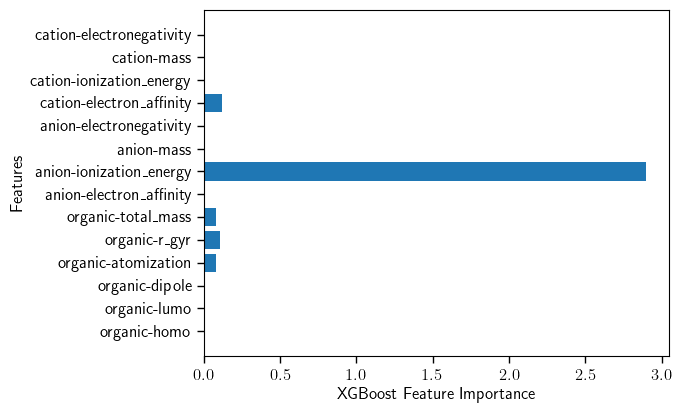

In [17]:
run_folder = '/Users/maitreyeesharma/WORKSPACE/PostDoc/Chemistry/SPIRAL/codes/RL/RL_FS/scripts/'

# Reading the input json file with dataset filename and path information
with open(run_folder+'inputs.json', "r") as f:
    input_dict = json.load(f)

input_type = input_dict['InputType']
input_path = input_dict['InputPath']
input_file = input_dict['InputFile']

# input_type='SynthData'
# input_path='/Users/maitreyeesharma/WORKSPACE/PostDoc/Chemistry/SPIRAL/codes/RL/RL_FS/synthetic_dataset/'
# input_file='synthetic_data_randomSamples_200_nonlinearf5.csv'    

input_data = inputs(input_type=input_type,
                           input_path=input_path,
                           input_file=input_file)

# input_data = inputs()
X_data, Y_data, descriptors = input_data.read_inputs()
X_stand, X_stand_df, scalerX = utilsd.standardize_data(X_data)
Y_stand, Y_stand_df, scalerY = utilsd.standardize_data(pd.DataFrame({'target':Y_data[:,0]}))

env = environment()
expert_trainer = predictor_models()

best_state = [0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1]
# for synth data new on grid with linear coarse grain [1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1]
# for synth data new on grid with multiplication coarse grain [1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1] 
# for synth data new with multiplication coarse grain [0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1] 
# for synth data new with linear coarse grain [1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1] 
# for synth data in nestedAE [0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0] 
# for chan: [1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0]; 
# for gryffin: [0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1]
descriptors = X_stand_df.columns
print(descriptors)
selected_descriptors = [i for i, x in enumerate(best_state) if x == 1]
X_stand_training = pd.DataFrame(X_stand_df, columns=descriptors[selected_descriptors])
Y_stand_training = Y_stand_df
# XGboost data for training policy
feature_importance_dict_rl, mse_game_rl = expert_trainer.xgboost(X_stand_training,Y_stand_training,selected_descriptors,descriptors,onlyImportant=False,plot_fig=True)


In [9]:
mse_game_rl

0.06003026435110278

In [10]:
# importance_df_rl.to_csv('/Users/maitreyeesharma/WORKSPACE/Publications/2024/q49/figs/SoA_our_method_compare_gryffin/rl.csv')

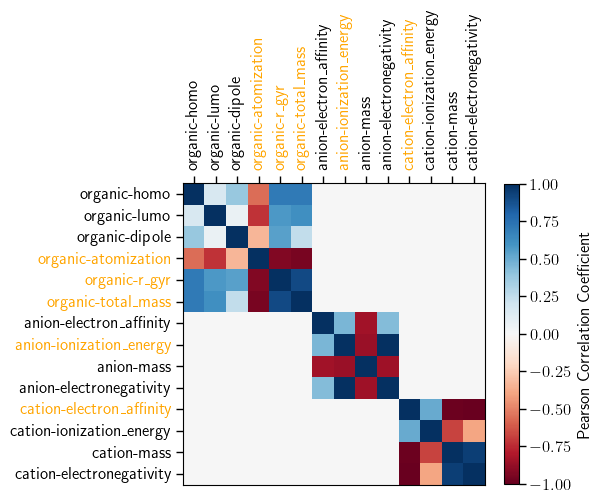

In [18]:
import scipy
import itertools

# Pearson correlation coefficients
def pearson_corr_coeff(x,y):

    rho_coeff=[]
    rho_coeff = scipy.stats.pearsonr(x, y)
    return rho_coeff.statistic

pcc = []
for i in range(len(descriptors)):
    for j in range(len(descriptors)):
        pcc.append(pearson_corr_coeff(X_stand_df[descriptors[i]],X_stand_df[descriptors[j]]))
        
pcc_matrix = np.array(pcc,dtype=np.float32) 
pcc_matrix = np.reshape(pcc_matrix,(len(descriptors),len(descriptors)))

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
cax = ax.imshow(pcc_matrix,cmap='RdBu',vmin=-1, vmax=1)
ax.xaxis.tick_top()
ax.xaxis.set_ticks(list(itertools.chain(range(0,len(descriptors)))))
ax.xaxis.set_ticklabels(descriptors,rotation=90)
ax.yaxis.set_ticks(list(itertools.chain(range(0,len(descriptors)))))
ax.yaxis.set_ticklabels(descriptors)
id_tick_change_colour_list = [3,4,5,7,10]

for id_tick_change_colour in id_tick_change_colour_list:
    plt.setp(ax.get_xticklabels()[id_tick_change_colour], color='orange')
    plt.setp(ax.get_yticklabels()[id_tick_change_colour], color='orange')
    
fig.colorbar(cax,label='Pearson Correlation Coefficient', shrink=0.68)
plt.tight_layout()
# plt.savefig('/Users/maitreyeesharma/WORKSPACE/Publications/2024/q49/figs/SoA_our_method_compare_matrix-gryffin/SoA_our_method_compare_matrix-gryffin.pdf', bbox_inches='tight', dpi=300)
